In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Preparation

## 1.1. Dataset Wrapper

In [3]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        self.X = self.X.unsqueeze(1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## 1.2. Model Preparation

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :]) 
        return out

# 2. Main Pipeline

In [5]:
class FPTPredictionPipeline:
    def __init__(self, target_col, test_size=0.15, hidden_size=64, num_layers=2, batch_size=64, learning_rate=0.001):
        self.target_col = target_col
        self.test_size = test_size
        self.batch_size = batch_size
        self.scaler_X = StandardScaler()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lr = learning_rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def preprocess_data(self, df):
        print("--- [1] Preprocessing Data ---")
        data = df.copy()
        
        # Sắp xếp thời gian
        if 'date' in data.columns:
            data['date'] = pd.to_datetime(data['date'])
            data = data.sort_values('date').set_index('date')

        feature_cols = [c for c in data.columns if c != self.target_col]
        
        print(f"Features used ({len(feature_cols)}): {feature_cols}")
        
        X = data[feature_cols].values
        y = data[self.target_col].values

        # Chia Train/Test
        split_idx = int(len(data) * (1 - self.test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        # Scale dữ liệu
        X_train_scaled = self.scaler_X.fit_transform(X_train)
        X_test_scaled = self.scaler_X.transform(X_test)
        
        self.input_dim = X_train_scaled.shape[1]
        
        # Tạo DataLoader
        train_loader = DataLoader(StockDataset(X_train_scaled, y_train), batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(StockDataset(X_test_scaled, y_test), batch_size=self.batch_size, shuffle=False)
        
        return train_loader, test_loader

    def build_and_train(self, train_loader, epochs=50):
        print(f"--- [2] Training Model ({self.input_dim} features) ---")
        self.model = LSTMModel(self.input_dim, self.hidden_size, self.num_layers).to(self.device)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()
        loss_history = []
        
        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            
            loss_history.append(total_loss/len(train_loader))
            
            if (epoch+1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")

        return loss_history

    def evaluate(self, test_loader):
        print("--- [3] Evaluating ---")
        self.model.eval()
        preds, actuals = [], []
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(self.device)
                outputs = self.model(X_batch)

                preds.extend(outputs.cpu().numpy().flatten())
                actuals.extend(y_batch.numpy().flatten())
        
        # Tính toán các chỉ số
        rmse = np.sqrt(mean_squared_error(actuals, preds))
        r2 = r2_score(actuals, preds)
        
        print(f"RMSE: {rmse:.5f}")
        print(f"R2 Score: {r2:.5f}")
        
        return pd.DataFrame({'Actual': actuals, 'Predicted': preds})
    
    def visualize_predictions(self, results_df, title="LSTM Prediction: Actual vs Predicted"):
        """Vẽ biểu đồ so sánh kết quả"""
        plt.figure(figsize=(14, 6))
        
        plt.plot(results_df.index, results_df['Actual'], label='Actual Log Return', color='blue', alpha=0.7)
        
        plt.plot(results_df.index, results_df['Predicted'], label='Predicted Log Return', color='red', linestyle='--', alpha=0.9)
        
        plt.title(title, fontsize=16)
        plt.xlabel('Time Step (Test Set)', fontsize=12)
        plt.ylabel('Log Return Value', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# 3. Pipeline

In [6]:
df = pd.read_csv(r'..\..\data\predictive_modeling.csv', index_col='date')
df.head()

,fpt_stock_price_log_return_scaled,market_cap_log_return,fpt_stock_price_log_return,gdp_value,cpi_rate,fpt_stock_price,fpt_stock_volume_log_return,fpt_net_revenue_log_return,usd_vnd_rate_log_return,xau_usd_rate_log_return
date,,,,,,,,,,
2020-01-01,-0.055765,0.0,0.000000,3.466157e+11,0.0643,21.39,0.000000,0.0,0.000194,0.009066
2020-01-02,-0.055765,0.0,0.000000,3.466157e+11,0.0643,21.39,0.000000,0.0,0.000194,0.009066
2020-01-03,-1.040504,0.0,-0.016974,3.466157e+11,0.0643,21.03,0.825817,0.0,-0.000043,0.014361
2020-01-06,-0.665883,0.0,-0.010516,3.466157e+11,0.0643,20.81,-0.629106,0.0,0.000151,0.018648
2020-01-07,1.048811,0.0,0.019039,3.466157e+11,0.0643,21.21,-0.265344,0.0,0.000043,-0.003361


In [7]:
cols_to_drop = ['fpt_stock_price', 'fpt_stock_price_log_return_scaled']
df_clean = df.drop(columns=cols_to_drop, errors='ignore')
print("Các cột còn lại sau khi drop:\n", df_clean.columns)

Các cột còn lại sau khi drop:
 Index(['market_cap_log_return', 'fpt_stock_price_log_return', 'gdp_value',
       'cpi_rate', 'fpt_stock_volume_log_return', 'fpt_net_revenue_log_return',
       'usd_vnd_rate_log_return', 'xau_usd_rate_log_return'],
      dtype='object')


In [8]:
pipeline = FPTPredictionPipeline(
    target_col='fpt_stock_price_log_return',
    batch_size=2
)

In [9]:
train_loader, test_loader = pipeline.preprocess_data(df_clean)

--- [1] Preprocessing Data ---
Features used (7): ['market_cap_log_return', 'gdp_value', 'cpi_rate', 'fpt_stock_volume_log_return', 'fpt_net_revenue_log_return', 'usd_vnd_rate_log_return', 'xau_usd_rate_log_return']


In [ ]:
loss_history = pipeline.build_and_train(train_loader, epochs=50)

--- [2] Training Model (7 features) ---


In [ ]:
results = pipeline.evaluate(test_loader)

--- [3] Evaluating ---
RMSE: 0.02226
R2 Score: -0.47877


# 4. Visualize


--- [4] Visualizing Results ---


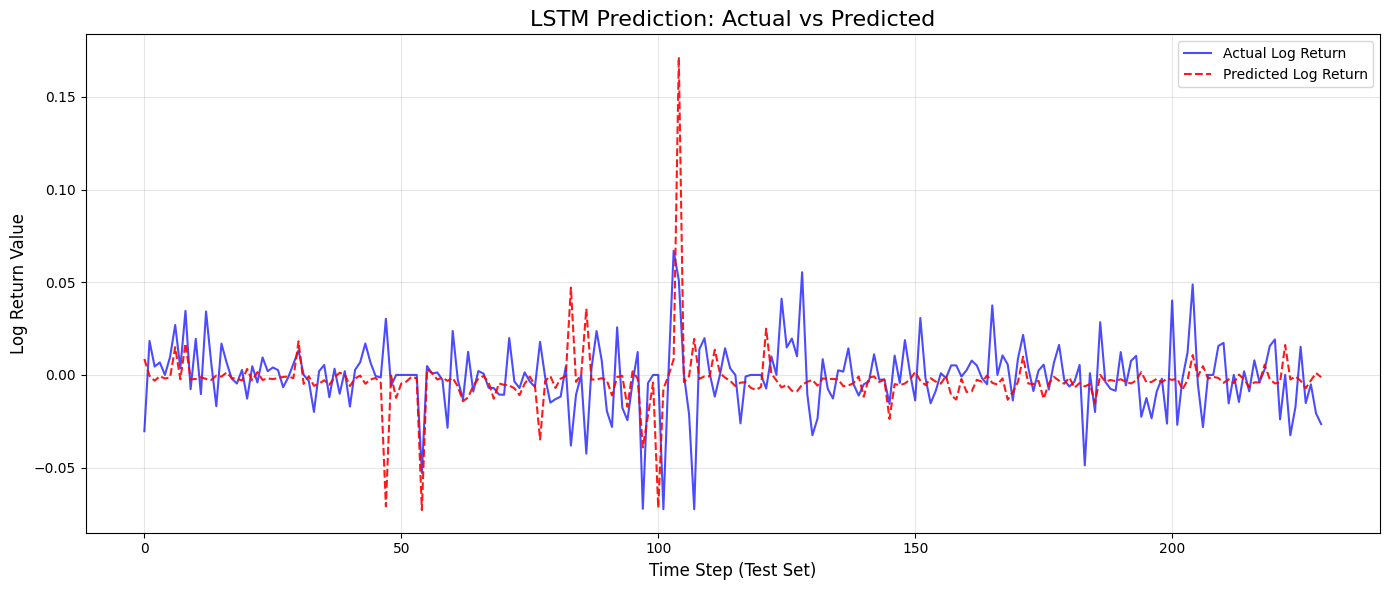

In [ ]:
print("\n--- [4] Visualizing Results ---")
pipeline.visualize_predictions(results)

In [ ]:
print(loss_history)

None


In [ ]:
   
# (Tùy chọn) Vẽ biểu đồ Loss để xem quá trình học
plt.figure(figsize=(10, 4))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()